# LSTM+CNN with multiple district outputs

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout,
    Input, InputLayer, concatenate, GlobalMaxPooling2D, Reshape
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.ndimage import gaussian_filter
import cv2
import pickle

In [2]:
df = pd.read_csv("chicago_2021_to_2024.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791351 entries, 0 to 791350
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Date                           791351 non-null  object 
 1   IUCR                           791351 non-null  object 
 2   Primary Type                   791351 non-null  object 
 3   Latitude                       791351 non-null  float64
 4   Longitude                      791351 non-null  float64
 5   Month                          791351 non-null  int64  
 6   Season                         791351 non-null  object 
 7   Year                           791351 non-null  int64  
 8   District                       791351 non-null  int64  
 9   Beat                           791351 non-null  int64  
 10  geometry                       791351 non-null  object 
 11  Community Name                 791351 non-null  object 
 12  Community Area Number         

In [60]:
#missing values?
na_count = df.isna().sum()
print(na_count)

Date                             0
IUCR                             0
Primary Type                     0
Latitude                         0
Longitude                        0
Month                            0
Season                           0
Year                             0
District                         0
Beat                             0
geometry                         0
Community Name                   0
Community Area Number            0
NIBRS                            0
Description                      0
Category                         0
Crime Against Category           0
district_name                    0
temperature_2m_max_day           0
temperature_2m_min_day           0
apparent_temperature_mean_day    0
daylight_duration_day            0
sunshine_duration_day            0
precipitation_sum_day            0
rain_sum_day                     0
snowfall_sum_day                 0
precipitation_hours_day          0
apparent_temperature_hour        0
precipitation_hour  

In [61]:
# Inspecting the districts
df_num_unique_districts = df['District'].nunique()
print(f"Number of unique districts: {df_num_unique_districts}")

# Count occurrences of each unique district
df_district_counts = df['District'].value_counts()
print("Counts of each district:")
print(df_district_counts)

Number of unique districts: 23
Counts of each district:
8     50008
6     48660
12    46688
4     45393
11    44867
1     41552
18    40661
25    40441
19    40439
3     40379
2     39051
7     34831
9     34729
10    33654
5     33081
16    29035
24    27867
14    27390
15    27387
22    25268
17    23129
20    16793
31       48
Name: District, dtype: int64


In [42]:
# Excluding district 31 because there is not enough information
df = df[df['District'] != 31]

In [43]:
# Checking it worked
df_num_unique_districts = df['District'].nunique()
print(f"Number of unique districts: {df_num_unique_districts}")

df_district_counts = df['District'].value_counts()
print("Counts of each district:")
print(df_district_counts)

Number of unique districts: 22
Counts of each district:
8     50008
6     48660
12    46688
4     45393
11    44867
1     41552
18    40661
25    40441
19    40439
3     40379
2     39051
7     34831
9     34729
10    33654
5     33081
16    29035
24    27867
14    27390
15    27387
22    25268
17    23129
20    16793
Name: District, dtype: int64


In [44]:
# clean column names
df.columns
df.rename(columns={
    'Date': 'time_stamp',    
    'Hour': 'hour',
    'DayOfWeek': 'day_of_week',
    'Month': 'month',
    'Season': 'season',
    'Year': 'year',
    
    'Primary Type': 'primary_type',
    'Description': 'description',
    'Category':'category',
    'Crime Against Category':'crime_against_category', 
    
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'District':'district', 
    'Beat': 'beat',
    'Community Name': 'community_name',
    'Community Area Number': 'community_area_number',
    
    'TOT_POP': 'tot_pop',
    'UNEMP': 'unemp',
    'INC_LT_25K': 'inc_lt_25k'
}, inplace=True)

#clean datatypes
print(df.dtypes)

df['time_stamp'] = pd.to_datetime(df['time_stamp'])
categorical_columns = ['season', 'primary_type', 'category', 'crime_against_category', 'community_name']
df[categorical_columns] = df[categorical_columns].astype('category')

#new variable: date
df['date'] = df['time_stamp'].dt.date
df['date'] = pd.to_datetime(df['date'])

#new variable: week_in_year
df['week_in_year'] = df['date'].dt.strftime('%Y-%U')

time_stamp                        object
IUCR                              object
primary_type                      object
latitude                         float64
longitude                        float64
month                              int64
season                            object
year                               int64
district                           int64
beat                               int64
geometry                          object
community_name                    object
community_area_number              int64
NIBRS                             object
description                       object
category                          object
crime_against_category            object
district_name                     object
temperature_2m_max_day           float64
temperature_2m_min_day           float64
apparent_temperature_mean_day    float64
daylight_duration_day            float64
sunshine_duration_day            float64
precipitation_sum_day            float64
rain_sum_day    

In [45]:
#preparation heatmap: group data by week and district
num_features = [
    'temperature_2m_max_day', 'temperature_2m_min_day', 'apparent_temperature_mean_day',
    'daylight_duration_day', 'sunshine_duration_day', 'precipitation_sum_day',
    'rain_sum_day', 'snowfall_sum_day', 'precipitation_hours_day', 
    'apparent_temperature_hour', 'precipitation_hour', 'rain_hour', 
    'snowfall_hour', 'cloud_cover_hour', 'wind_speed_100m_hour', 
    'tot_pop', 'unemp', 'inc_lt_25k'
]

#aggregation of the data by district and week, and calculation of the median
df['crimes_per_week'] = 1  #add a helper column to count the crimes

#aggregation of the data by district and week, and calculation of the median
data = df.groupby(['district', 'week_in_year']).agg(
    total_crimes=('crimes_per_week', 'sum'),  #count the number of crimes
    **{var: (var, 'median') for var in num_features}  #calculate the median of numerical features
).reset_index()

#output the aggregated df
display(data.head())

district week_in_year  total_crimes  temperature_2m_max_day  \
0         1      2021-00            33                  1.2565   
1         1      2021-01           117                  1.8065   
2         1      2021-02           129                  3.3565   
3         1      2021-03           124                 -0.0935   
4         1      2021-04            97                 -0.4435   

   temperature_2m_min_day  apparent_temperature_mean_day  \
0                 -1.5935                      -4.218307   
1                 -2.4435                      -4.954852   
2                 -3.2935                      -4.316140   
3                 -7.4935                      -9.478119   
4                 -3.3935                      -8.301347   

   daylight_duration_day  sunshine_duration_day  precipitation_sum_day  \
0              33186.530              158.77258                    0.9   
1              33484.440            14796.29800                    0.0   
2              33968.230            10171.92400                    0.0   
3              34691.320            27065.20700                    0.0   
4              35658.246             1782.03080                    2.2   

   rain_sum_day  ...  precipitation_hours_day  apparent_temperature_hour  \
0           0.2  ...                      3.0                  -6.057571   
1           0.0  ...                      0.0                  -4.279955   
2           0.0  ...                      0.0                  -5.394463   
3           0.0  ...                      0.0                  -9.825356   
4           0.0  ...                      6.0                  -7.871385   

   precipitation_hour  rain_hour  snowfall_hour  cloud_cover_hour  \
0                 0.0        0.0            0.0         86.400000   
1                 0.0        0.0            0.0         89.100000   
2                 0.0        0.0            0.0         73.800000   
3                 0.0        0.0            0.0         26.849999   
4                 0.0        0.0            0.0         88.500000   

   wind_speed_100m_hour      tot_pop   unemp  inc_lt_25k  
0             21.413190  38655.00002  1281.0      2667.0  
1             19.602652  38655.00002  1281.0      2667.0  
2             27.064720  38655.00002  1281.0      2667.0  
3             24.014996  38655.00002  1281.0      2667.0  
4             25.478743  38655.00002  1281.0      2667.0  

[5 rows x 21 columns]

In [46]:
def create_heatmap_array(data, map_size=(256, 256), radius=5):
    """
    creates a heatmap as a numpy array based on latitude and longitude
    
    parameters:
    - data: df with the columns 'latitude', 'longitude', 'crimes_per_week'
    - map_size: size of the heatmap (height, width)
    - radius: radius of the heatmap points
    
    returns:
    - heatmap_array: numpy array of the specified map_size
    """
    #initialize array
    heatmap_array = np.zeros(map_size)

    #normalize latitude and longitude to map size
    lat_min, lat_max = data['latitude'].min(), data['latitude'].max()
    lon_min, lon_max = data['longitude'].min(), data['longitude'].max()

    #check if lat_max equals lat_min or lon_max equals lon_min
    if lat_max == lat_min:
        lat_max += 0.001  #adjust slightly to avoid zero division
    if lon_max == lon_min:
        lon_max += 0.001  #adjust slightly to avoid zero division

    #scaling function
    def scale_lat_lon(lat, lon):
        x = int((lon - lon_min) / (lon_max - lon_min) * (map_size[1] - 1))
        y = int((lat - lat_min) / (lat_max - lat_min) * (map_size[0] - 1))
        return x, y

    for _, row in data.iterrows():
        x, y = scale_lat_lon(row['latitude'], row['longitude'])
        heatmap_array[y, x] += row['crimes_per_week']

    return heatmap_array

# create a heatmap for a week and a district, and resize it to 256x256
def create_and_resize_heatmap(week_data, map_size=(256, 256), radius=5):
    heatmap_array = create_heatmap_array(week_data, map_size=map_size, radius=radius)
    heatmap_resized = cv2.resize(heatmap_array, map_size)
    return heatmap_resized

# list of variables for which the median was calculated
num_features = [
    'temperature_2m_max_day', 'temperature_2m_min_day', 'apparent_temperature_mean_day',
    'daylight_duration_day', 'sunshine_duration_day', 'precipitation_sum_day',
    'rain_sum_day', 'snowfall_sum_day', 'precipitation_hours_day', 
    'apparent_temperature_hour', 'precipitation_hour', 'rain_hour', 
    'snowfall_hour', 'cloud_cover_hour', 'wind_speed_100m_hour', 
    'tot_pop', 'unemp', 'inc_lt_25k'
]

In [47]:
# Sorting districts to be able to map the output to each district
districts = data['district'].unique()
num_districts = len(districts)
print(districts)

[ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 22 24 25]


In [48]:
# Initialize lists
X_images_sequences = []
X_socio_sequences = []
y_labels_sequences = []

window_size = 10  # number of weeks in the sliding window
max_weeks = 208   # maximum number of weeks to be processed

# Iterate over all districts
for neighborhood in districts:
    neighborhood_data = data[data['district'] == neighborhood]
    neighborhood_data = neighborhood_data.sort_values('week_in_year')
    
    # Limit to the first XX weeks
    neighborhood_data = neighborhood_data.head(max_weeks)
    
    for i in range(len(neighborhood_data) - window_size):
        window_data = neighborhood_data.iloc[i:i + window_size]
        next_week_data = neighborhood_data.iloc[i + window_size]
        
        # Create heatmap sequence
        heatmaps_sequence = np.array([
            create_and_resize_heatmap(df[(df['district'] == neighborhood) & (df['week_in_year'] == week)])
            for week in window_data['week_in_year']
        ])
        
        # Create socio-economic feature sequence
        socio_sequence = window_data[num_features].values
        
        # Append sequences
        X_images_sequences.append(heatmaps_sequence)
        X_socio_sequences.append(socio_sequence)
        
        # Store the crime counts for all districts in the target week
        all_districts_crime_counts = data[data['week_in_year'] == next_week_data['week_in_year']]['total_crimes'].values
        y_labels_sequences.append(all_districts_crime_counts)

In [49]:
# Get the current working directory of the notebook
current_dir = os.getcwd()

# Define the filename 
filename = '2021_2024_sequences_complete.pkl'

# Create the full path by joining the current directory and the filename
save_path = os.path.join(current_dir, filename)

# Save the data to a file
with open(save_path, 'wb') as f:
    pickle.dump((X_images_sequences, X_socio_sequences, y_labels_sequences), f)

print(f"Data has been successfully saved to {save_path}.")


Data has been successfully saved to /home/scc/miranda.barros-everett/model/2021_2024_sequences_complete.pkl.


In [ ]:
'''
# In case the pickle was already created and stored, please adjust path as necessary
# Define the path to the pickle file
load_path = r"/home/scc/miranda.barros-everett/model/2021_2024_sequences.pkl"

# Open the pickle file and load the data
with open(load_path, 'rb') as f:
    X_images_sequences, X_socio_sequences, y_labels_sequences, district_mapping = pickle.load(f)
'''

In [50]:
window_size = 10
# Convert lists to numpy arrays
X_images_sequences = np.array(X_images_sequences)
X_socio_sequences = np.array(X_socio_sequences)
y_labels_sequences = np.array(y_labels_sequences)

# Print shapes before normalization
print("Shapes before normalization:")
print("X_images_sequences shape:", X_images_sequences.shape)
print("X_socio_sequences shape:", X_socio_sequences.shape)
print("y_labels_sequences shape:", y_labels_sequences.shape)

# Normalize the socio-economic data
scaler_socio = StandardScaler()
X_socio_sequences = scaler_socio.fit_transform(X_socio_sequences.reshape(-1, X_socio_sequences.shape[-1])).reshape(X_socio_sequences.shape)

# Normalize the crime counts for each district separately
scaler_y_labels = StandardScaler()

# Reshape y_labels_sequences to 2D (number of samples x number of districts)
y_labels_flat = y_labels_sequences.reshape(-1, y_labels_sequences.shape[-1])
y_labels_normalized = scaler_y_labels.fit_transform(y_labels_flat)

# Reshape back to the original 3D shape (number of samples x window_size x number of districts)
y_labels_sequences = y_labels_normalized.reshape(y_labels_sequences.shape)

print()
# Print shapes after normalization
print("Shapes after normalization:")
print("X_images_sequences shape:", X_images_sequences.shape)
print("X_socio_sequences shape:", X_socio_sequences.shape)
print("y_labels_sequences shape:", y_labels_sequences.shape)

# Prepare data for training
X_images_sequences = X_images_sequences.reshape((X_images_sequences.shape[0], window_size, 256, 256, 1))

# Split the data
X_images_train, X_images_test, X_socio_train, X_socio_test, y_train, y_test = train_test_split(
    X_images_sequences, X_socio_sequences, y_labels_sequences, test_size=0.1, random_state=42
)

print()
# Print shapes after splitting
print("Shapes after train/test split:")
print("X_images_train shape:", X_images_train.shape)
print("X_images_test shape:", X_images_test.shape)
print("X_socio_train shape:", X_socio_train.shape)
print("X_socio_test shape:", X_socio_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Shapes before normalization:
X_images_sequences shape: (3828, 10, 256, 256)
X_socio_sequences shape: (3828, 10, 18)
y_labels_sequences shape: (3828, 22)

Shapes after normalization:
X_images_sequences shape: (3828, 10, 256, 256)
X_socio_sequences shape: (3828, 10, 18)
y_labels_sequences shape: (3828, 22)

Shapes after train/test split:
X_images_train shape: (3445, 10, 256, 256, 1)
X_images_test shape: (383, 10, 256, 256, 1)
X_socio_train shape: (3445, 10, 18)
X_socio_test shape: (383, 10, 18)
y_train shape: (3445, 22)
y_test shape: (383, 22)


In [51]:
# Model architecture
input_images = Input(shape=(window_size, 256, 256, 1))

# CNN layers with batch normalization 
x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))(input_images)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Flatten())(x)

# LSTM layers on image features
x = LSTM(50, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01))(x)
x = LSTM(50, activation='tanh', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x) 

input_socio = Input(shape=(window_size, X_socio_train.shape[2]))

# LSTM layer on socio-economic data 
y = LSTM(50, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01))(input_socio)
y = LSTM(50, activation='tanh', kernel_regularizer=l2(0.01))(y)
y = Dropout(0.5)(y)  

combined = concatenate([x, y])

# Fully connected layers with dropout and L2 regularization
z = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(combined)
z = Dropout(0.5)(z)  

# Output layer modified to predict per district
output = Dense(num_districts, activation='relu')(z)
# alternative two:
#output = Dense(num_districts, activation='softplus')(z)

# Compile the model
model = Model(inputs=[input_images, input_socio], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summarize the model
model.summary()

# Callbacks for dynamic learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history = model.fit(
    [X_images_train, X_socio_train], y_train,
    validation_data=([X_images_test, X_socio_test], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 10, 256, 256, 1)]    0         []                            
                                                                                                  
 time_distributed_30 (TimeD  (None, 10, 256, 256, 32)     320       ['input_7[0][0]']             
 istributed)                                                                                      
                                                                                                  
 time_distributed_31 (TimeD  (None, 10, 256, 256, 32)     128       ['time_distributed_30[0][0]'] 
 istributed)                                                                                      
                                                                                            

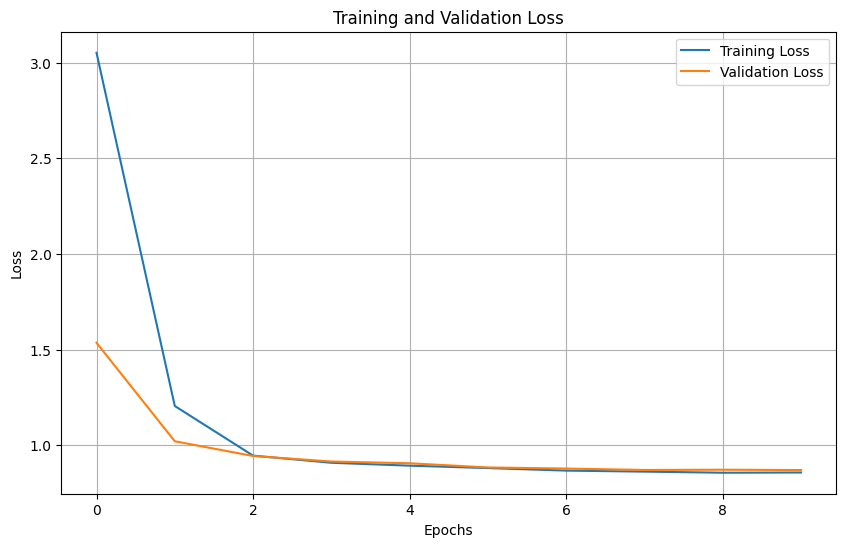

In [52]:
# ETraining and validation loss visualization
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# Loading predicton
y_pred = model.predict([X_images_test, X_socio_test])

12/12 [==============================] - 7s 495ms/step


In [54]:
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, y_pred)
print("R-squared Score:", r2)

print("Mean of y_test:", np.mean(y_test))
print("Mean of y_pred:", np.mean(y_pred))

print("Variance of y_test:", np.var(y_test))
print("Variance of y_pred:", np.var(y_pred))

Mean Squared Error: 0.8528049100306344
R-squared Score: 0.16132125781211634
Mean of y_test: -0.003361301748793715
Mean of y_pred: 0.18560934
Variance of y_test: 1.0173447013767185
Variance of y_pred: 0.07691672


In [55]:
# Display predictions
num_samples_to_show = 1  # Number of samples to display
print("True Values (First few samples):")
print(y_test[:num_samples_to_show])

print("Predicted Values (First few samples):")
print(y_pred[:num_samples_to_show])

True Values (First few samples):
[[0.17140752 0.41098817 1.18413178 1.88012668 0.04568367 1.18525451
  0.61328902 1.2036261  0.98561347 1.07045551 0.70119752 0.81677872
  0.26921839 0.13264733 1.4380703  1.00906293 1.09829459 1.13699274
  0.30405654 0.5339962  1.1932499  0.94030712]]
Predicted Values (First few samples):
[[0.5580921  0.7319042  0.6495286  0.640985   0.53210956 0.61139876
  0.45836765 0.67532897 0.6851111  0.6813727  0.5593151  0.6897116
  0.6221539  0.54096305 0.620815   0.53338933 0.6698678  0.7981092
  0.6119889  0.5269148  0.5942034  0.64039296]]


In [56]:
# Unnormalize predictions
y_pred_flat = y_pred.reshape(-1, y_pred.shape[-1])
y_pred_original = scaler_y_labels.inverse_transform(y_pred_flat)
y_pred_sequences = y_pred_original.reshape(y_pred.shape)

# Unnormalize true values
y_test_flat = y_test.reshape(-1, y_test.shape[-1])
y_test_original = scaler_y_labels.inverse_transform(y_test_flat)
y_test_sequences = y_test_original.reshape(y_test.shape)

# Print some values for comparison
num_samples_to_show = 1 # Number of samples to display

print("Unnormalized True Values (First few samples):")
print(y_test_sequences[:num_samples_to_show])

print("Unnormalized Predicted Values (First few samples):")
print(y_pred_sequences[:num_samples_to_show])

Unnormalized True Values (First few samples):
[[244. 235. 269. 331. 183. 315. 210. 336. 225. 221. 274. 307. 161. 154.
  202. 155. 277. 287.  99. 152. 193. 261.]]
Unnormalized Predicted Values (First few samples):
[[269.46356 249.29745 247.98058 277.81958 197.13574 292.1108  205.31224
  309.37967 214.85808 208.13219 268.22626 299.6506  172.88908 164.50836
  177.38347 142.2234  257.36804 268.50876 105.19871 151.82486 173.40932
  248.78445]]


In [58]:
predicted_values = y_pred_sequences[0]
true_values = y_test_sequences[0]

# Create and store in a new dataframe
df_2 = pd.DataFrame({
    'District': districts,
    'True Value': true_values,
    'Predicted Value': predicted_values
})

display(df_2)


District  True Value  Predicted Value
0          1       244.0       269.463562
1          2       235.0       249.297455
2          3       269.0       247.980576
3          4       331.0       277.819580
4          5       183.0       197.135742
5          6       315.0       292.110809
6          7       210.0       205.312241
7          8       336.0       309.379669
8          9       225.0       214.858078
9         10       221.0       208.132187
10        11       274.0       268.226257
11        12       307.0       299.650604
12        14       161.0       172.889084
13        15       154.0       164.508362
14        16       202.0       177.383469
15        17       155.0       142.223404
16        18       277.0       257.368042
17        19       287.0       268.508759
18        20        99.0       105.198708
19        22       152.0       151.824860
20        24       193.0       173.409317
21        25       261.0       248.784454